In [1]:
from scipy.io import loadmat

In [2]:
from PIL import Image

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import pandas as pd

In [25]:
from shapely.geometry import Polygon

ModuleNotFoundError: No module named 'shapely'

In [21]:
import os

In [22]:
import networkx as nx

In [23]:
from tqdm import tqdm_notebook

In [24]:
from datetime import datetime, timedelta
from dateutil import relativedelta

In [8]:
from scipy.optimize import linear_sum_assignment

In [10]:
patients_df = pd.read_excel("data/Initial & repeat MRI in MS-Free Dataset/PatientCodes-Names.xls")

In [46]:
edss_df = pd.read_csv("data/edss.csv")

In [13]:
patients_df.drop(0, inplace=True)

In [14]:
patients_df.drop(columns=["Unnamed: 7", "Unnamed: 6"], inplace=True)

In [15]:
patients_df.head()

,N,Date Of bitrh,Date of Exam,Age at onset,Unnamed: 4,CODE
1,1.0,1970-01-05,2004-05-24,34.0,NaN,AT
2,2.0,1973-10-20,2003-11-12,30.0,NaN,AA
3,3.0,1953-05-15,2003-01-14,50.0,NaN,GPE
4,4.0,1981-03-29,2004-02-11,23.0,NaN,HC
5,5.0,1983-07-21,2004-07-21,21.0,NaN,IO


In [16]:
patients_df.columns

Index(['N', 'Date Of bitrh ', 'Date of Exam ', 'Age at onset ', 'Unnamed: 4',
       'CODE'],
      dtype='object')

In [17]:
patients_df["Date of Exam "] = pd.to_datetime(patients_df["Date of Exam "])

In [18]:
im = Image.open("data/Initial & repeat MRI in MS-Free Dataset/AA/2/IM_00239.TIF")
lesion_scan = np.array(im)

# Get by months

2009-2010 years

In [37]:
date1 = datetime.strptime(str('2011-08-15 12:00:00'), '%Y-%m-%d %H:%M:%S')
date2 = datetime.strptime(str('2012-02-15'), '%Y-%m-%d')

In [38]:
def months_diff(date1, date2):
    return relativedelta.relativedelta(date2, date1).years * 12 + relativedelta.relativedelta(date2, date1).months

In [48]:
dates = []
percentages = []

for end_days in tqdm_notebook(range(0, 365 * 10)):
    end_date = datetime(2005, 1, 1) + timedelta(days=end_days)
    current_months = set(patients_df["Date of Exam "].apply(lambda x: months_diff(x, end_date)))
    inter = current_months.intersection(initial_months)
    dates.append(end_date)
    percentages.append(len(inter) / len(initial_months))

C:\Users\msubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


NameError: name 'initial_months' is not defined

In [40]:
end_date = dates[np.argmax(percentages)]

ValueError: attempt to get argmax of an empty sequence

In [41]:
months_diff(patients_df["Date of Exam "].iloc[0], end_date)

7

In [45]:
initial_months = set(edss_df["months"])

KeyError: 'months'

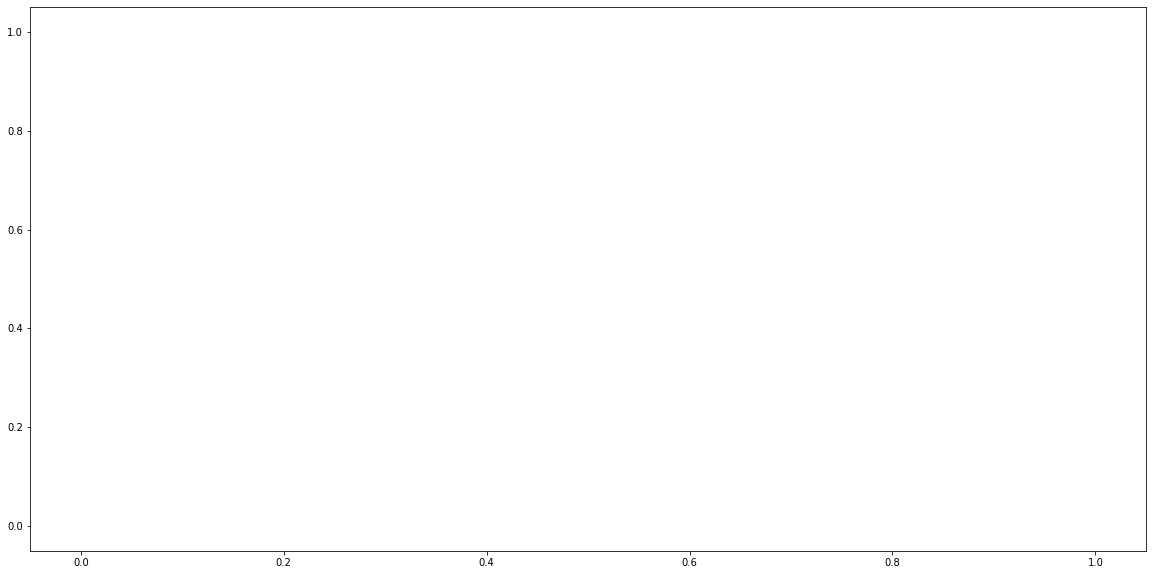

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(dates, percentages)

In [44]:
patients_df["months"] = patients_df["Date of Exam "].apply(lambda x: months_diff(x, end_date))

# Match by 3d lesions

In [49]:
def process_plq(path, z_index, polygon):
    params = loadmat(path)
    shape = params["yi"].reshape(-1).shape[0]
    return list(zip(
        params["xi"].reshape(-1), 
        params["yi"].reshape(-1), 
        [z_index] * shape,
        [polygon] * shape
    ))

In [50]:
def read_points(path):
    all_points = []
    for root, _, files in os.walk(path):
        for index, file in enumerate(sorted([f for f in files if ".plq" in f])):
            z_index = int(file.split("_")[1].split(".")[0])
            path = root + "/" + file
            all_points += process_plq(path, z_index, index)
    points_df = pd.DataFrame(all_points, columns=["x", "y", "z_index", "polygon"])
    points_df["x_mm"] = points_df["x"] / 2.26
    points_df["y_mm"] = points_df["y"] / 2.26
    points_df["z_mm"] = (points_df["z_index"] - points_df["z_index"].min()) * 5
    return points_df

In [51]:
def create_extended_polygon(points_df, polygon_index, buffer=10):
    polygon_points = points_df[points_df["polygon"] == polygon_index][["x", "y"]].values.tolist()
    polygon = Polygon(polygon_points).buffer(buffer)
    try:
        areas = [p.area for p in polygon]
        return polygon[np.argmax(areas)]
    except:
        return polygon.exterior

In [52]:
def intersected(points_df, polygon_one, polygon_two):
    polygon_one_object = create_extended_polygon(points_df, polygon_one)
    polygon_two_object = create_extended_polygon(points_df, polygon_two)
    return polygon_one_object.intersects(polygon_two_object)

In [53]:
def create_graph(points_df):
    nodes = points_df["polygon"].unique().tolist()
    edges = []
    z_indices = sorted(points_df["z_index"].unique().tolist())
    for prev_index, z_index in enumerate(z_indices[1:]):
        prev_z_index = z_indices[prev_index]
        if prev_z_index + 1 < z_index:
            continue
        polygons = points_df[points_df["z_index"] == z_index]["polygon"].unique().tolist()
        prev_polygons = points_df[points_df["z_index"] == prev_z_index]["polygon"].unique().tolist()
# #         Uncomment to join polygons on the same level
#         for polygon_one in polygons:
#             for polygon_two in polygons:
#                 if polygon_two > polygon_one:
#                     if intersected(points_df, polygon_one, polygon_two):
#                         edges.append((polygon_one, polygon_two))
        for polygon in polygons:
            for prev_polygon in prev_polygons:
                if intersected(points_df, polygon, prev_polygon):
                    edges.append((prev_polygon, polygon))
    return nodes, edges

In [54]:
def get_lesions_number(path):
    points_df = read_points(path)
    nodes, edges = create_graph(points_df)  
    lesions_graph = nx.Graph()
    lesions_graph.add_nodes_from(nodes)
    lesions_graph.add_edges_from(edges)
    lesions = list(nx.connected_components(lesions_graph))
    return points_df, lesions

In [55]:
patients_to_lesions_df = patients_df[["CODE"]].copy().set_index("CODE")

In [56]:
for patient in tqdm_notebook(patients_to_lesions_df.index):
    for period in ["1", "2"]:
        path = "data/Initial & repeat MRI in MS-Free Dataset/{}/{}".format(patient, period)
        patients_to_lesions_df.loc[patient, "lesions_{}".format(period)] = len(get_lesions_number(path)[1])

C:\Users\msubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


NameError: name 'Polygon' is not defined

In [427]:
patients_to_lesions_df.head()

,lesions_1,lesions_2
CODE,,
AT,6.0,7.0
AA,23.0,23.0
GPE,21.0,22.0
HC,9.0,14.0
IO,24.0,29.0


In [467]:
main_path = "./Initial & repeat MRI in MS-Free Dataset/TZN/2"

In [468]:
points_df, lesions = get_lesions_number(main_path)

In [469]:
points_df["lesion"] = points_df["polygon"].apply(lambda x: [i for i, e in enumerate(lesions) if x in e][0]).astype(str)

In [470]:
import plotly.express as px
fig = px.scatter_3d(points_df, x='x_mm', y='y_mm', z='z_mm', color="lesion", opacity=0.9)
fig.show()

# Total matching

In [432]:
edss_lesions_df = edss_df.set_index("subject")

In [440]:
patients_to_lesions_df["months"] = patients_df.set_index("CODE").loc[patients_to_lesions_df.index, "months"].tolist()

In [457]:
costs = np.zeros((len(patients_to_lesions_df.index), len(patients_to_lesions_df.index)))

for index_one, patient in enumerate(patients_to_lesions_df.index):
    for index_two, patient_index in enumerate(edss_lesions_df.index):
        cost = (patients_to_lesions_df.loc[patient]["lesions_1"] - edss_lesions_df.loc[patient_index]["Number1"]) ** 2 + \
                (patients_to_lesions_df.loc[patient]["lesions_2"] - edss_lesions_df.loc[patient_index]["Number2"]) ** 2 + \
                100 * (patients_to_lesions_df.loc[patient]["months"] - edss_lesions_df.loc[patient_index]["months"]) ** 2
        costs[index_one, index_two] = np.sqrt(cost)

In [458]:
patients, indices = linear_sum_assignment(costs)

In [472]:
pd.concat([patients_to_lesions_df.reset_index(), edss_lesions_df.iloc[indices].reset_index()], axis=1)[["CODE", "EDSS2", "EDSS5"]].to_csv("EDSS_matching.csv")